# AnomalyGenerator

In [421]:

%autoreload 2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import scipy as sp
import scipy.stats as sps
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import typing as tp
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.patches as mpatches
from AnomalyGenerator import Anomaly, AnomalyGenerator
from RobustRandomCutForest import LDCDRobustRandomCutForest
from AnomalyModelRunner import run_model_on_generator, show_model_results
sns.set()
%matplotlib inline

## 'Energy consumption in Germany' - dataset

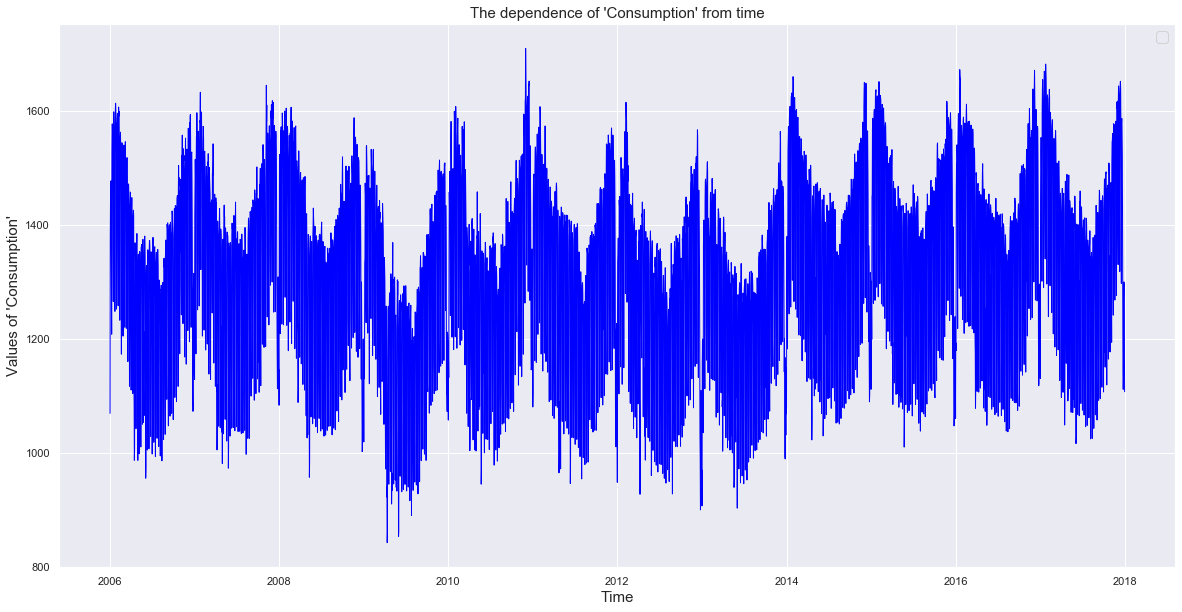

In [488]:
generator = AnomalyGenerator().read_data_from_file("opsd_germany_daily.csv",
                                                           "Date", 
                                                   type_of_time_column = "timeseries")
generator.show_data('Consumption')

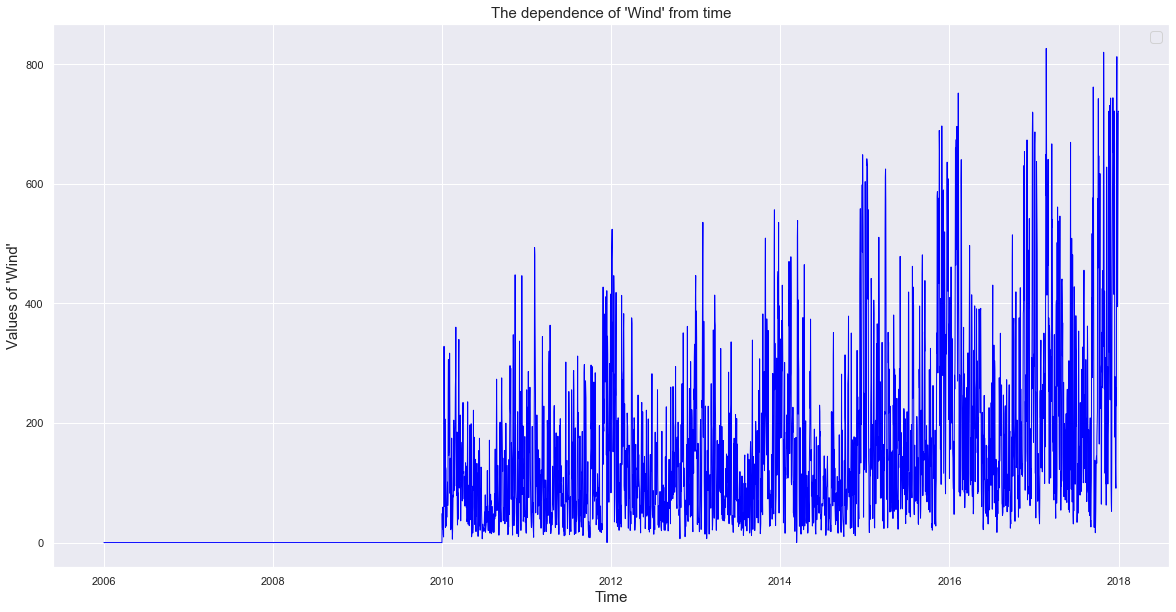

In [489]:
generator.show_data('Wind')

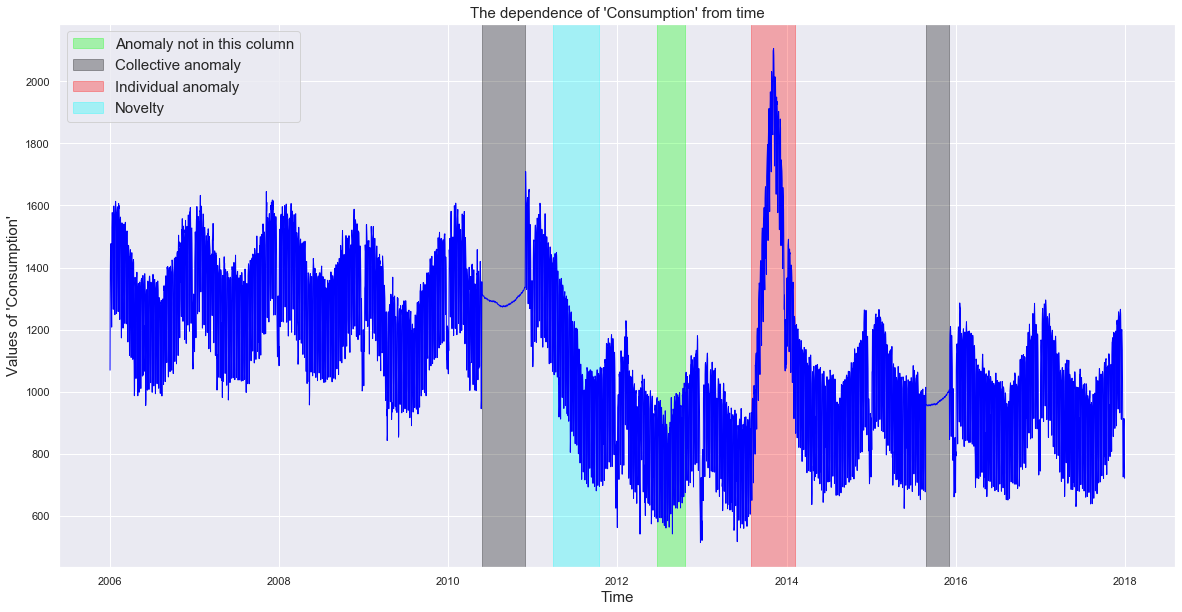

In [490]:
anomaly_types = {'Wind': [Anomaly.individual],
                 'Consumption': [Anomaly.collective,
                                 Anomaly.individual,
                                 Anomaly.novelty]}
generator.reset()
generator.add_anomalies(anomaly_types, pct_of_outliers = 0.25, minsize = 100, 
                            random_state = 42, length_of_normal_data_in_start = 1501)
generator.show_data('Consumption')

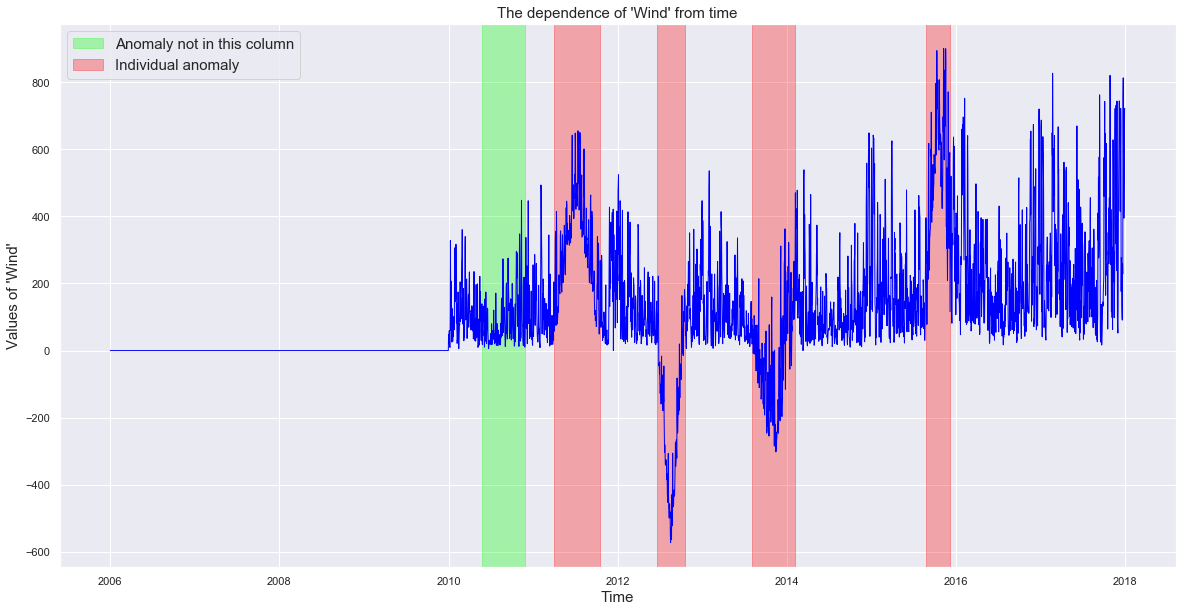

In [491]:
generator.show_data('Wind')

In [453]:
pvals, predicted_anomaly_indexes = \
run_model_on_generator(LDCDRobustRandomCutForest, 
                       generator, train_size=700, queue_size=300)

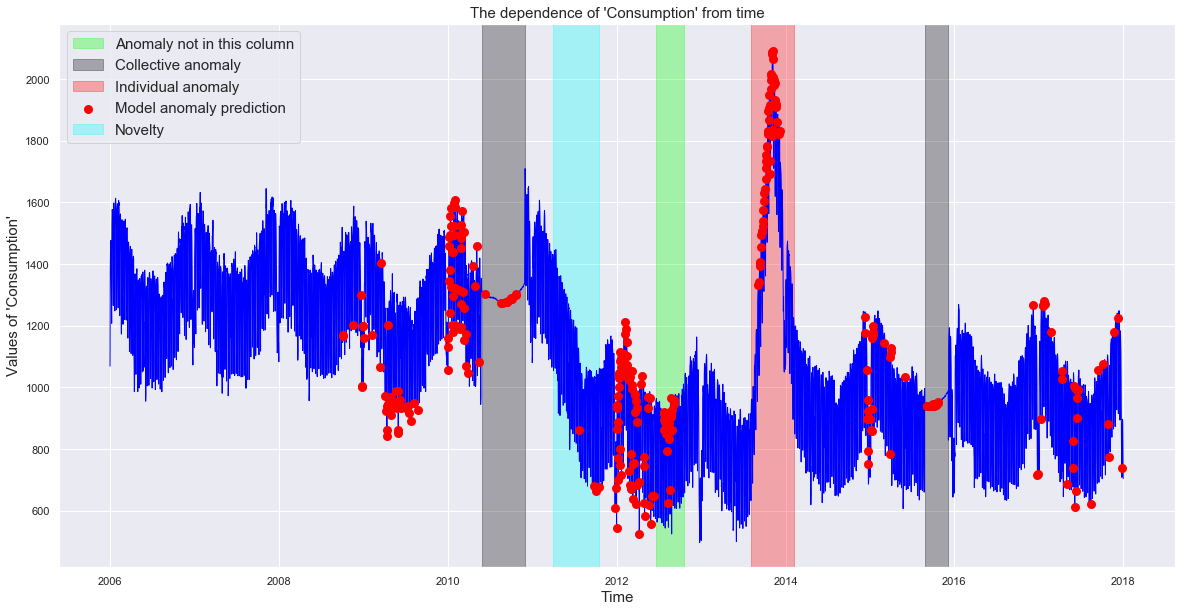

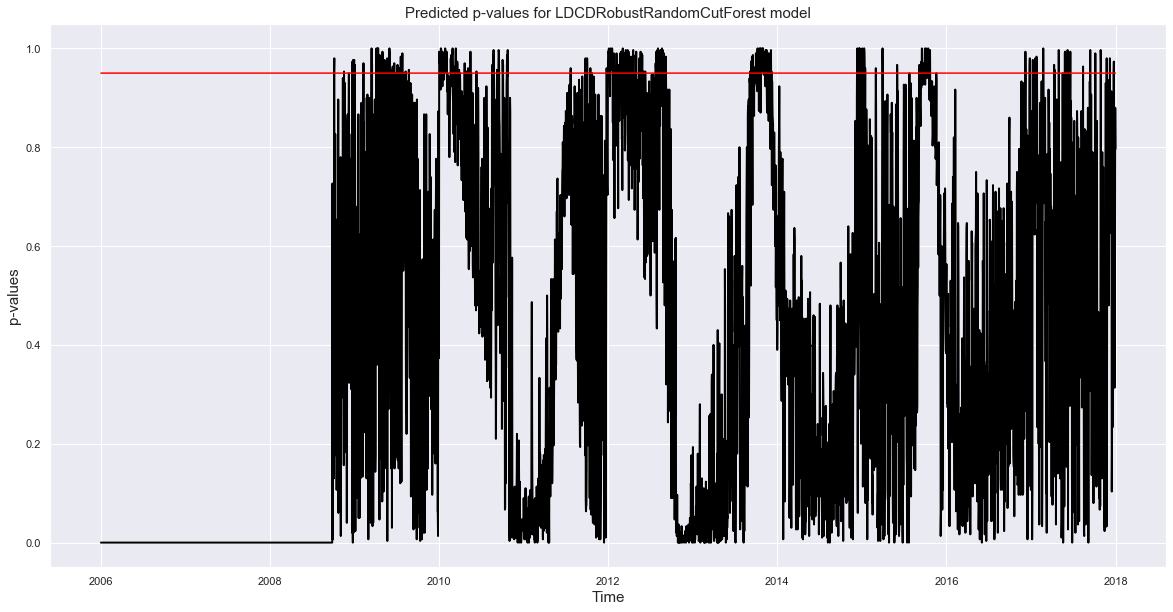

In [461]:
show_model_results('Consumption', "LDCDRobustRandomCutForest", 
                   generator, pvals, alpha=0.95)

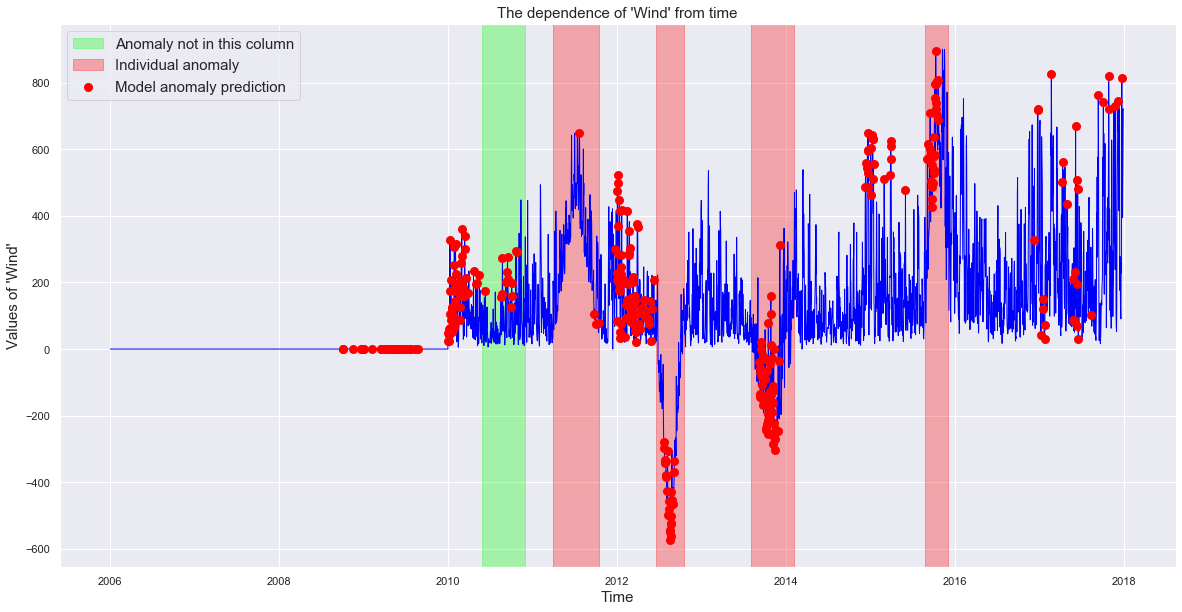

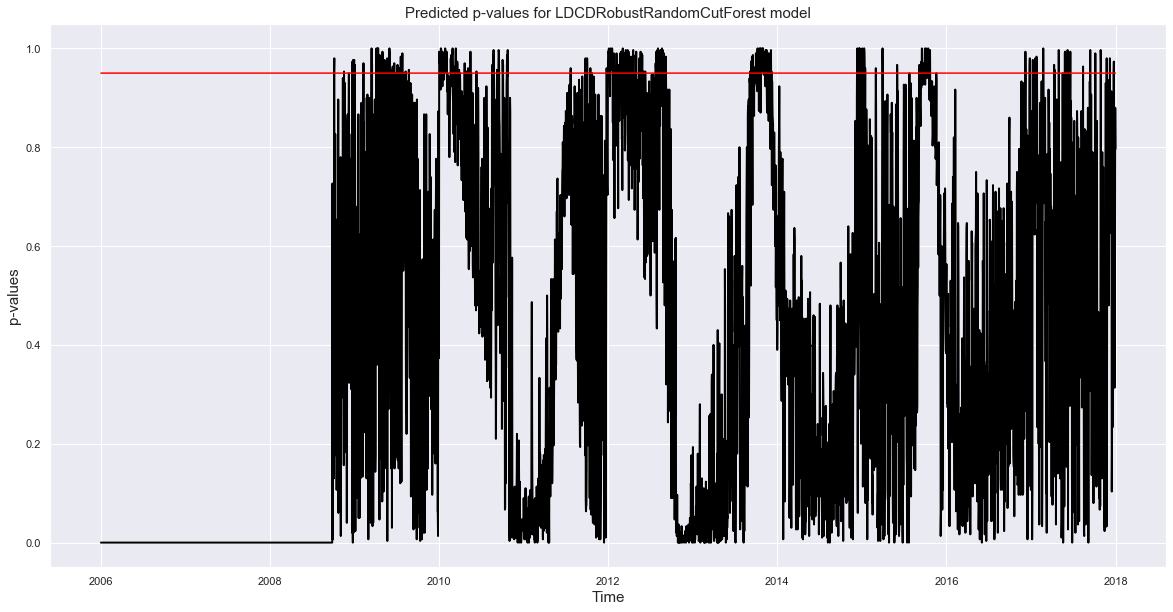

In [462]:
show_model_results('Wind', "LDCDRobustRandomCutForest", 
                   generator, pvals, alpha=0.95)

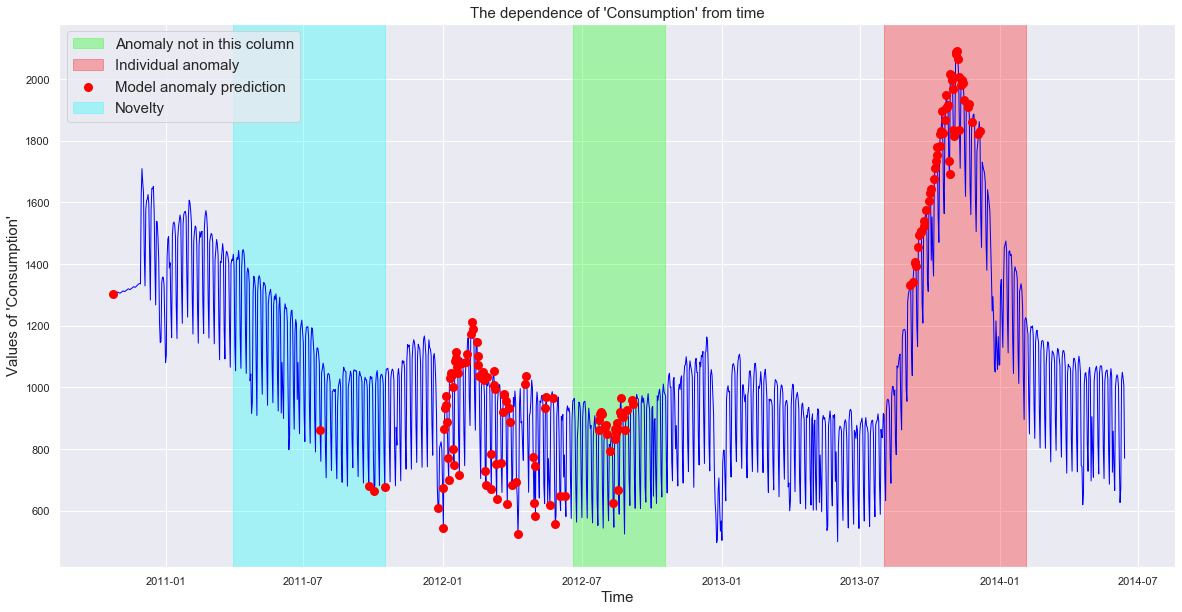

In [463]:
generator.show_anomaly(
    'Consumption', 2, predicted_anomaly_points=predicted_anomaly_indexes)

## Artificial dataset

In [475]:
size = 10000
data = np.arange(0, size)
x = np.sin(data) + sps.norm(0, 0.5).rvs(size)
data = np.concatenate([data.reshape(-1, 1), x.reshape(-1, 1)], axis = 1)
df = pd.DataFrame(data, columns = ['Time', 'X'])

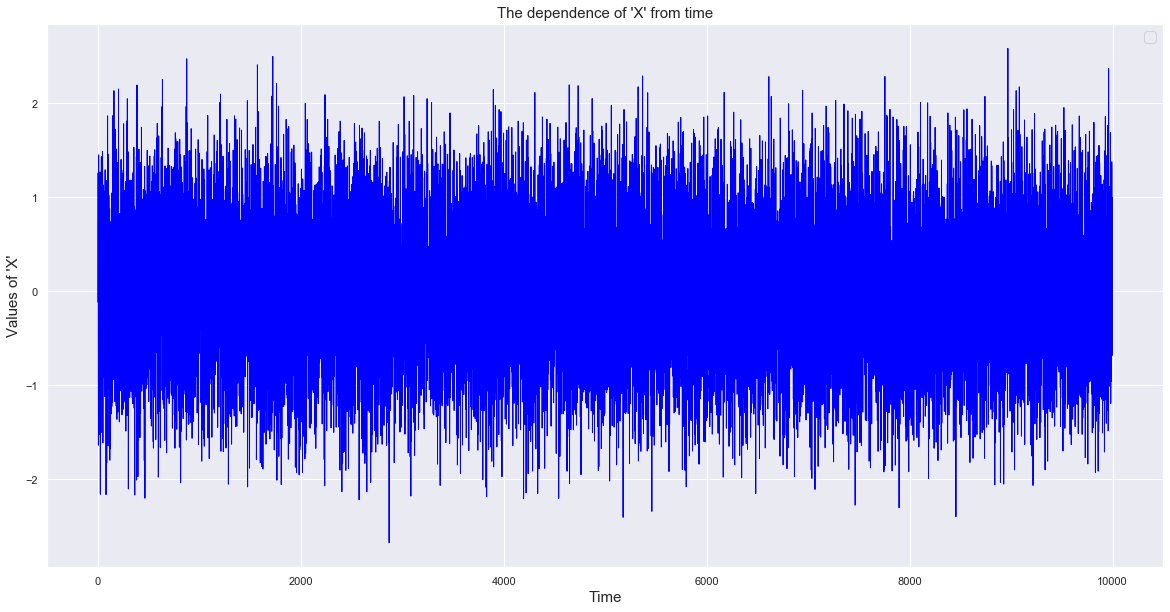

In [480]:
new_generator = AnomalyGenerator().read_data_from_pd_dataframe(df, "Time", 
                                                   type_of_time_column = "float")
new_generator.show_data('X')

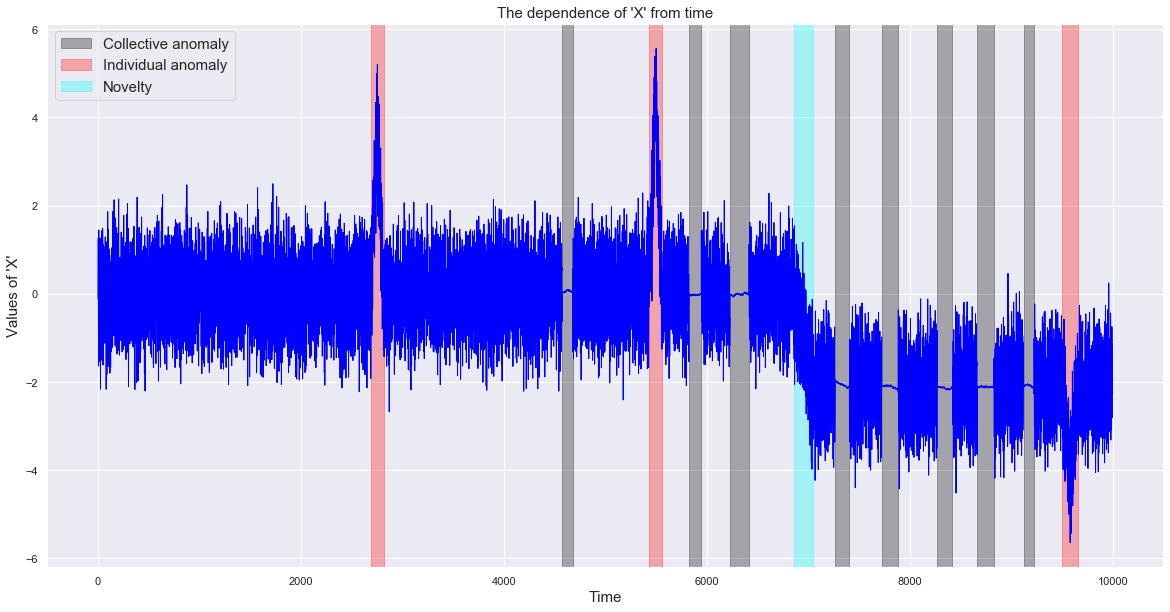

In [481]:
anomaly_types = {'X': [Anomaly.collective,
                        Anomaly.individual,
                        Anomaly.novelty]}
new_generator.add_anomalies(anomaly_types, pct_of_outliers = 0.25, minsize = 100, 
                            random_state = 42, length_of_normal_data_in_start = 1001)
new_generator.show_data('X')

In [482]:
pvals, predicted_anomaly_indexes = \
run_model_on_generator(LDCDRobustRandomCutForest, 
                       new_generator, train_size=700, queue_size=700)

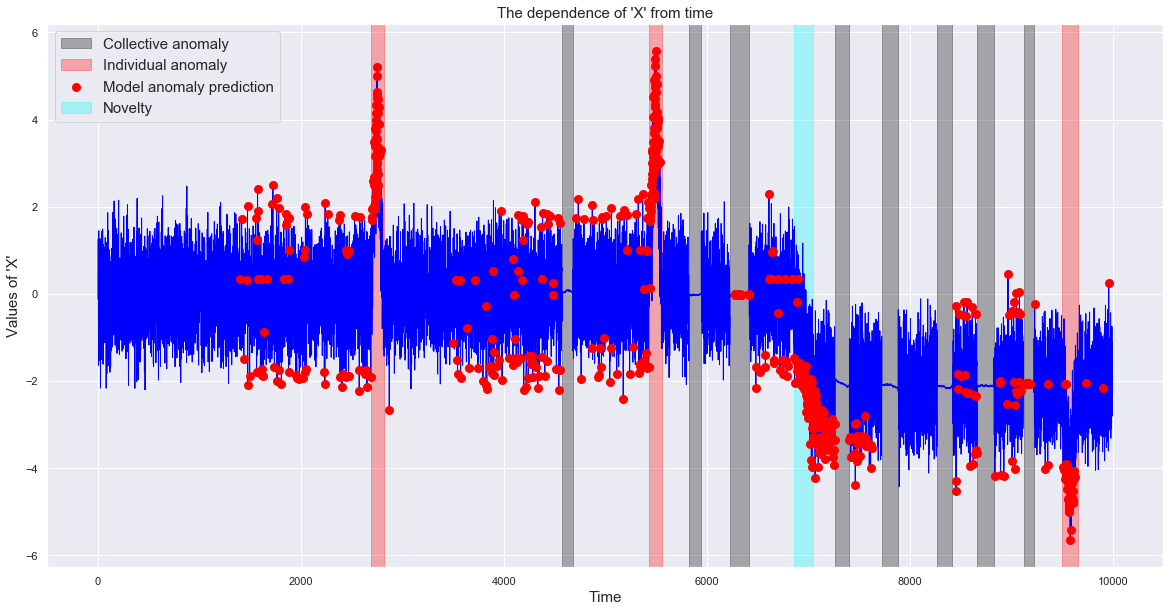

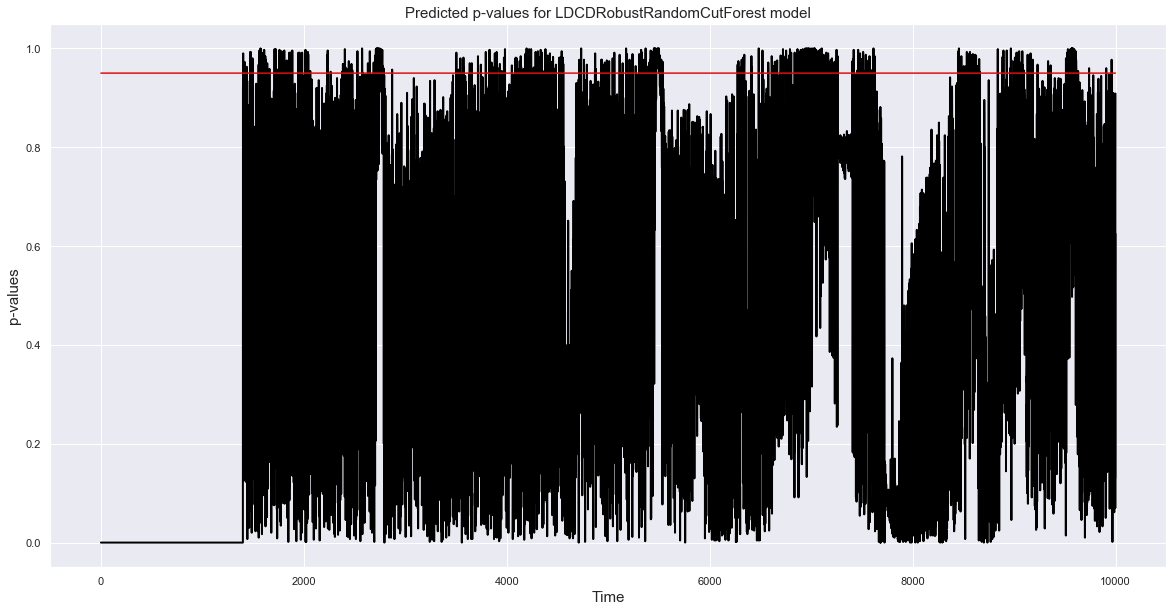

In [484]:
show_model_results('X', "LDCDRobustRandomCutForest", 
                   new_generator, pvals, alpha=0.95)

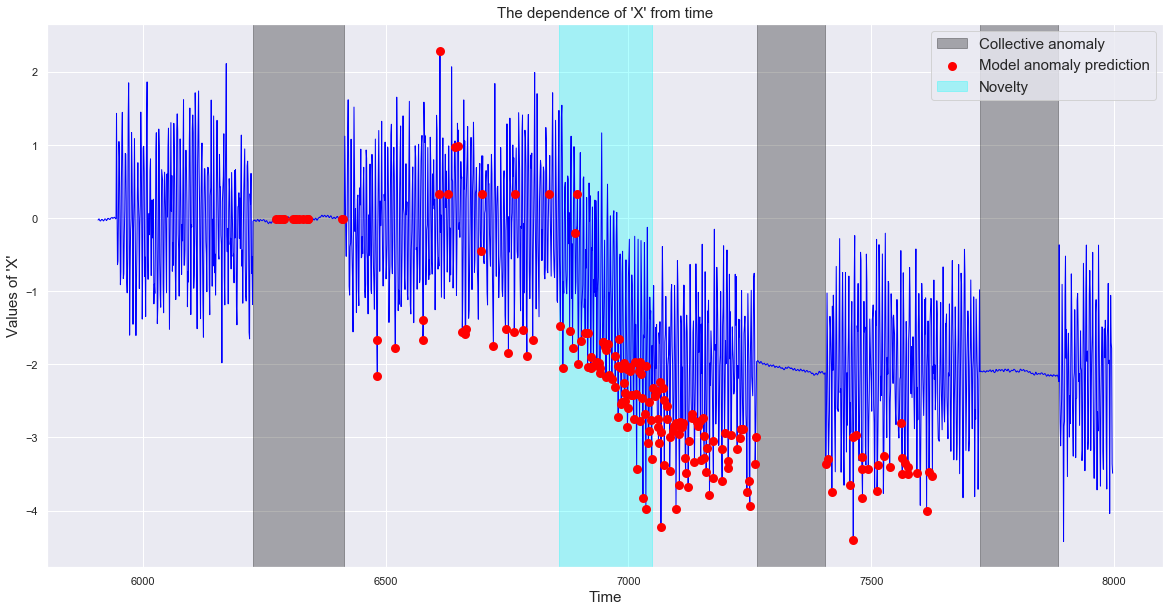

In [487]:
new_generator.show_anomaly(
    'X', 5, predicted_anomaly_points=predicted_anomaly_indexes)